## Import Libraries

In [1]:
import pyspark.pandas as ps
import pandas as pd
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
from pyspark.sql import SparkSession
import seaborn as sns
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, MapType

# Load spaCy's pre-trained model for English
nlp = spacy.load('en_core_web_md')
spark = SparkSession.builder.master('local[*]').config("spark.driver.memory", "6g").config("spark.executor.memory", "6g").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","20g").getOrCreate()
categories = ['AMAZON_FASHION', 'All_Beauty', 'Appliances' , 'Arts_Crafts_and_Sewing' , 'Automotive', 'Books', 'CDs_and_Vinyl', 'Cell_Phones_and_Accessories', 'Clothing_Shoes_and_Jewelry', 'Digital_Music', 'Electronics', 'Gift_Cards', 'Grocery_and_Gourmet_Food', 'Home_and_Kitchen', 'Industrial_and_Scientific', 'Kindle_Store', 'Luxury_Beauty', 'Magazine_Subscriptions', 'Movies_and_TV', 'Musical_Instruments', 'Office_Products', 'Patio_Lawn_and_Garden', 'Pet_Supplies', 'Prime_Pantry', 'Software', 'Sports_and_Outdoors', 'Tools_and_Home_Improvement', 'Toys_and_Games', 'Video_Games']
#categories = ['AMAZON_FASHION', 'All_Beauty', 'Appliances' , 'Arts_Crafts_and_Sewing']

/home/allorenz/.cache/pypoetry/virtualenvs/tu-dopp-ws23-U-ympmBJ-py3.11/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/23 00:29:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/23 00:29:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Helper Functions 
- Lemmatazation and Stop Word Removal 
- Word Count

In [2]:
def lemmatize_text_spacy(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(lemmatized_words)
# Register UDF for lemmatization
lemmatize_udf = udf(lemmatize_text_spacy, StringType())



def get_entities_with_counts(text):
    doc = nlp(text)
    word_counter = Counter([token.text for token in doc if token.pos_ in {'NOUN', 'VERB', 'ADJ'}])
    return dict(word_counter)
# Register UDF for counting NER
get_entities_with_counts_udf = udf(get_entities_with_counts, MapType(StringType(), StringType()))

Load reviews and retrieve word counts

In [3]:
word_counts_by_category = {}

for category in categories:
    entity_label_counter = Counter()
    word_counter = Counter()
    print(f'Processing {category}')
    
    # Load data into PySpark DataFrame
    spark_data = spark.read.parquet(f'/data/{category}.parquet')
    
    # Sample fraction of the DataFrame
    print("--- sampling ---")
    df_spark = spark_data.select("reviewText", "overall", "vote").sample(False, 0.001)
    
    # Filter out rows where "reviewText" is null
    print("--- filtering null values ---")
    df_spark = df_spark.filter(df_spark["reviewText"].isNotNull())
    
    # Lemmatize and Stop words removal
    print("--- lemmatizing ---")
    df_spark = df_spark.withColumn("reviewText", lemmatize_udf("reviewText"))
    
    # Word Counts
    df_spark = df_spark.withColumn("wordCounts", get_entities_with_counts_udf("reviewText"))
    df_spark_filtered = df_spark.filter(df_spark["wordCounts"].isNotNull())
    
    # Collect the results into a local Python list
    word_counts_list = df_spark_filtered.select("wordCounts").collect()
    print("--- getting word counts ---")
    # Update the entity_label_counter using the collected list
    for row in word_counts_list:
        if row['wordCounts'] is not None:
            # Convert values to integers before updating the Counter
            word_counts = {key: int(value) for key, value in row['wordCounts'].items()}
            word_counter.update(word_counts)


    word_counts_by_category[category] = word_counter

# result entity label
#stacked_df = entitiy_proportions.pivot(index='category', columns='Entity Label', values='Normalized Count')


Processing AMAZON_FASHION
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


24/01/23 00:30:00 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


--- getting word counts ---
Processing All_Beauty
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Appliances
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Arts_Crafts_and_Sewing
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Automotive
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Books
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing CDs_and_Vinyl
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Cell_Phones_and_Accessories
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Clothing_Shoes_and_Jewelry
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Digital_Music
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Electronics
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Gift_Cards
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Grocery_and_Gourmet_Food
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Home_and_Kitchen
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Industrial_and_Scientific
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Kindle_Store
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Luxury_Beauty
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Magazine_Subscriptions
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Movies_and_TV
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Musical_Instruments
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Office_Products
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Patio_Lawn_and_Garden
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Pet_Supplies
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Prime_Pantry
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Software
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Sports_and_Outdoors
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Tools_and_Home_Improvement
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Toys_and_Games
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---
Processing Video_Games
--- sampling ---
--- filtering null values ---
--- lemmatizing ---


--- getting word counts ---


## Wordcloud
Our assumption is that nouns, verbs, and adjectives might carry and reflect the most information about certain aspects of a product. A Wordcloud for each categoryy of top used part-of-speech is created to derive the most important aspects in each category.

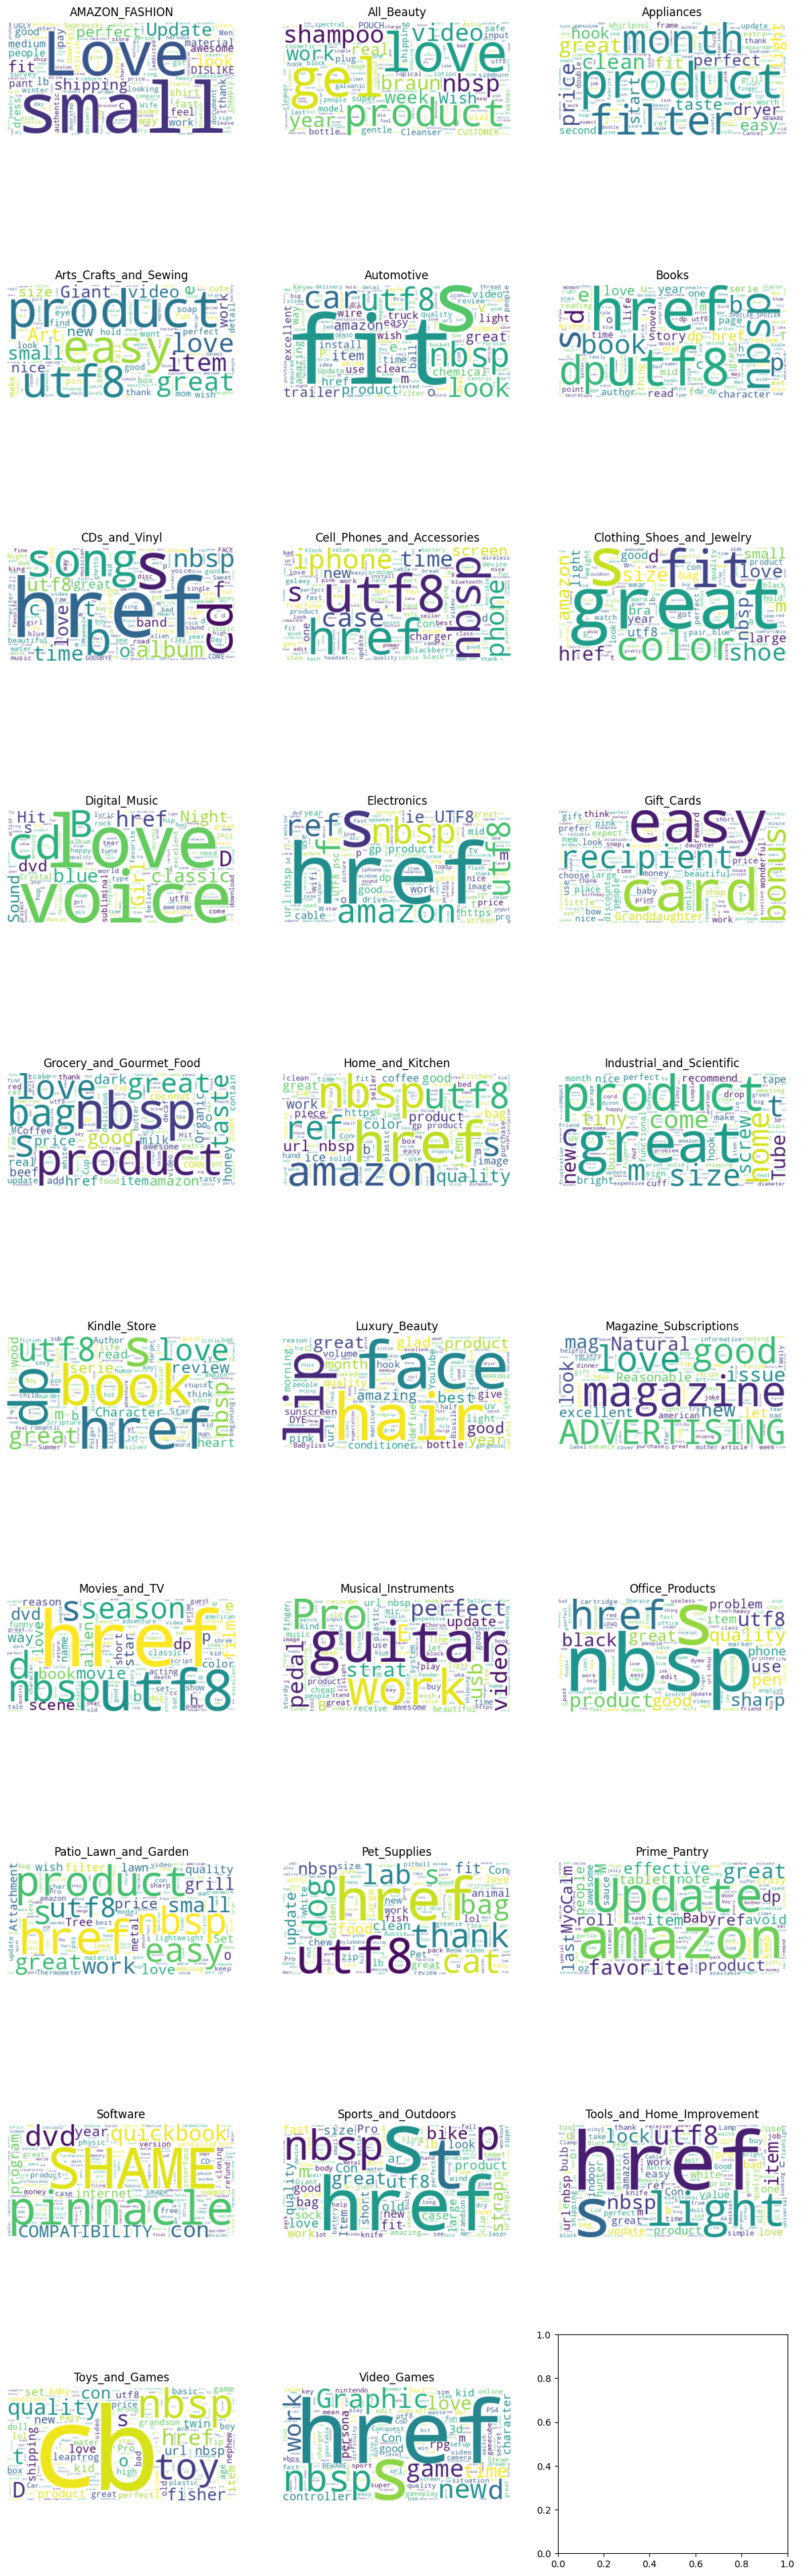

In [4]:
word_counts_by_category

# Plot the WordCloud images for each category
categories = list(word_counts_by_category.keys())
num_categories = len(categories)
plots_per_row = 3
num_rows = (num_categories + plots_per_row - 1) // plots_per_row  # Ceiling division to calculate rows

fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(15, 5*num_rows))

for i in range(num_rows):
    for j in range(plots_per_row):
        index = i * plots_per_row + j
        if index < num_categories:
            category = categories[index]
            word_counter = word_counts_by_category[category]

            wordcloud_text = " ".join(word for word in word_counter.keys())

            wordcloud = WordCloud(width=400, height=200, background_color='white').generate(wordcloud_text)

            axs[i, j].imshow(wordcloud, interpolation='bilinear')
            axs[i, j].set_title(category)
            axs[i, j].axis('off')

plt.show()


## Name Entity Recognition
NER shall help to identify and classify entities within the reviews by certain categories, to enhance our understanding of the mentioned aspects.
For evaluation, the proportion of referenced entities within each product category is estimated. The spaCy library is used, which has built-in recognition that encompasses 18 different entities. To inspect all possible labels, use the following code:
`nlp.get_pipe("ner").labels`

In [5]:
entitiy_proportions = pd.DataFrame()

for category, word_counter in word_counts_by_category.items():
    entity_label_counter = Counter()
    
    # Iterate through each word and count in the word counter
    for word, count in word_counter.items():
        doc = nlp(word)
        entities = [ent.label_ for ent in doc.ents]

        # Update entity_label_counter 
        entity_label_counter.update({entity: count for entity in entities})
    
    # Compute and store entity proportions
    sum_of_label_counts = sum(entity_label_counter.values())
    normalized_label_counts = {key: value / sum_of_label_counts for key, value in entity_label_counter.items()}

    # Create a DataFrame for the current category
    df_normalized_label_counts_by_category = pd.DataFrame(list(normalized_label_counts.items()), columns=['Entity Label', 'Normalized Count'])
    df_normalized_label_counts_by_category["category"] = category

    # Concatenate the current category DataFrame to entitiy_proportions
    entitiy_proportions = pd.concat([entitiy_proportions, df_normalized_label_counts_by_category], ignore_index=True)


stacked_df = entitiy_proportions.pivot(index='category', columns='Entity Label', values='Normalized Count')


<Figure size 1000x1400 with 0 Axes>

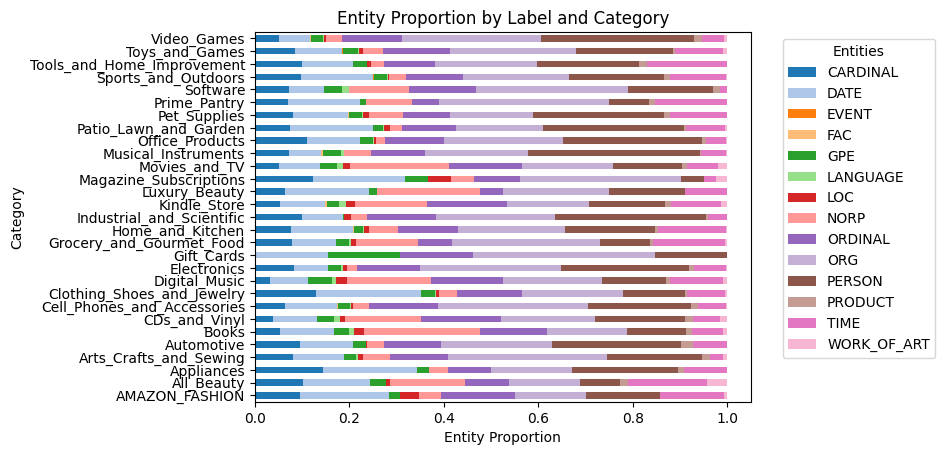

In [22]:
# Create a stacked horizontal barplot
sns.set_palette("tab20")
plt.figure(figsize=(10, 14))
stacked_df.plot(kind='barh', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Entities')
plt.title('Entity Proportion by Label and Category')
plt.xlabel("Entity Proportion")
plt.ylabel("Category")
plt.show()